In [2]:
import networkx as nx

# Figure 3

## CPC_IPSC Example

In [2]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="figures_material/networks/cpc_ipsc.bnet",  # or bnet_text=...
    max_per_row=3,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    osci_seed=42,
    x_gap=3, y_gap=3,          # grid spacing
    y_merge_threshold=1,           # NEW: merge Y with outputs if outputs count <= this
    node_shape="circle",           # "circle" or "ellipse" or anything Graphviz supports
    node_width=1, node_height=1,
    fontsize=14,
    output_dir="figures_material/figure_3",
    base_name="cpc_ipsc_graph_final",
    fontname="Dejavu Sans",
    bold_labels=True,
)
art


{'dot': 'figures_material\\figure_3\\cpc_ipsc_graph_final.dot',
 'png': 'figures_material\\figure_3\\cpc_ipsc_graph_final.png',
 'svg': 'figures_material\\figure_3\\cpc_ipsc_graph_final.svg',
 'positions_json': 'figures_material\\figure_3\\cpc_ipsc_graph_final_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 3,
 'max_per_row_input': None,
 'max_per_row_output': None}

In [10]:
import sys
sys.path.append("src")
import POKE
import util                   # from src/util.py
from copy import deepcopy

# Load parameters (same as CLI main() would do)
params = util.load_yaml("input/params.yaml")

all controllers        : [['!KLF4', '!NANOG', '!OCT4', '!SOX2'], ['!KLF4', '!Ripply2', 'Brachyury'], ['!KLF4', 'MESP1'], ['!NANOG', '!Ripply2', 'Brachyury', 'ISL1'], ['!NANOG', '!Ripply2', 'MESP1'], ['!Ripply2', 'Brachyury', 'CM'], ['CM', 'MESP1']]
relative heights       : [np.int64(1), np.int64(1)]
min controllers        : [['!KLF4', 'MESP1'], ['CM', 'MESP1']]
min robust controllers : [['!KLF4', 'MESP1'], ['CM', 'MESP1']]
mechanism data         : {'!KLF4 & MESP1': {'graph': <networkx.classes.digraph.DiGraph object at 0x0000015BFF40E8E0>, 'controller -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> target': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)]}, 'CM & MESP1': {'graph': <networkx.classes.digraph.DiGraph object at 0x0000015BFF437070>, 'controller -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> t

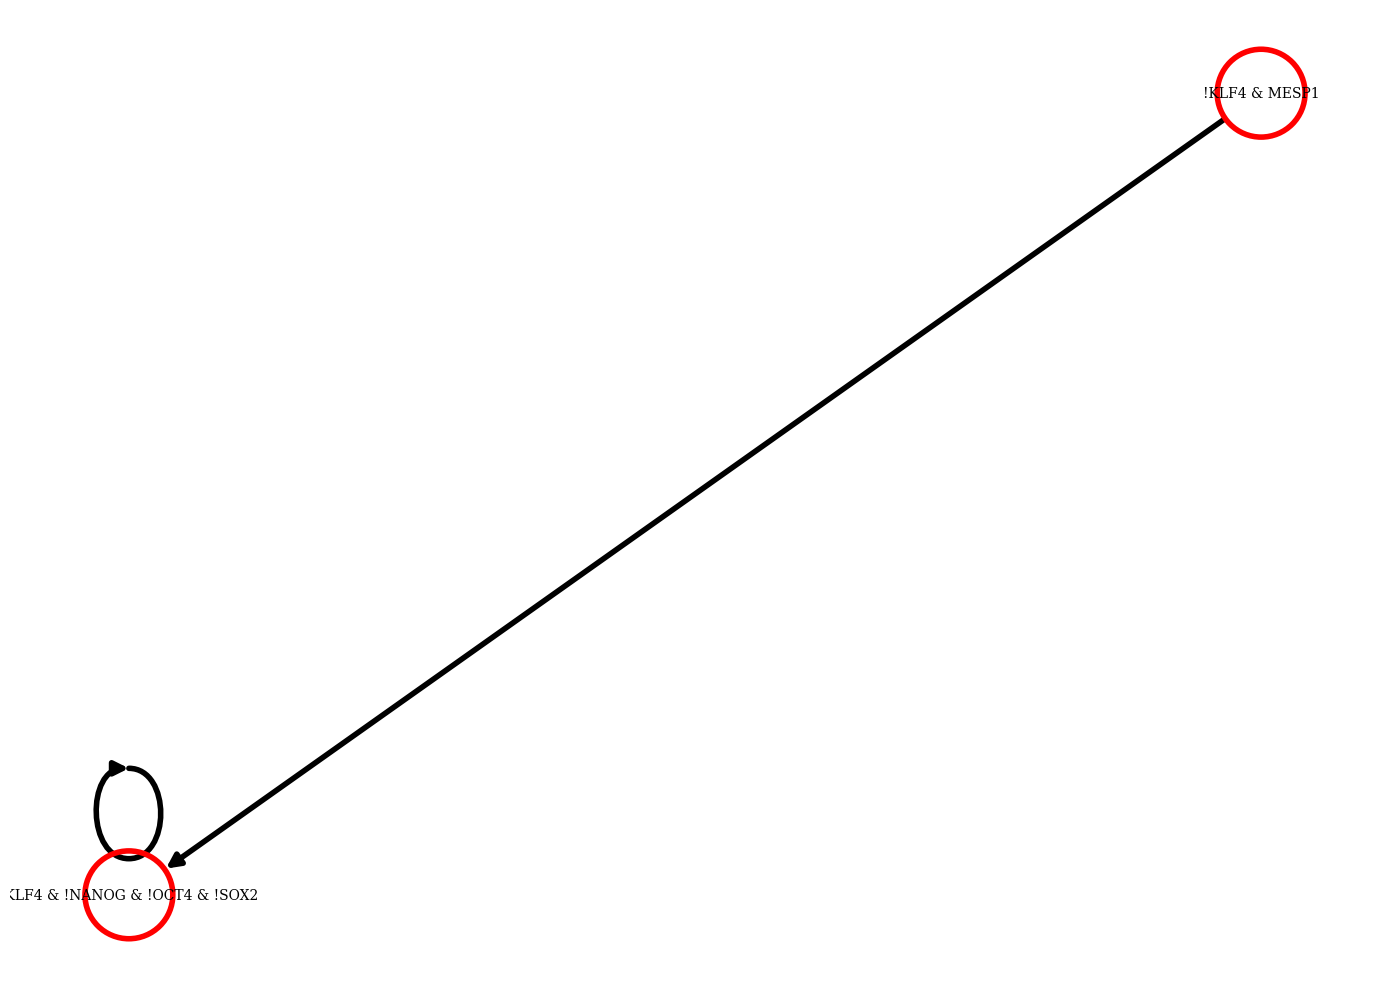

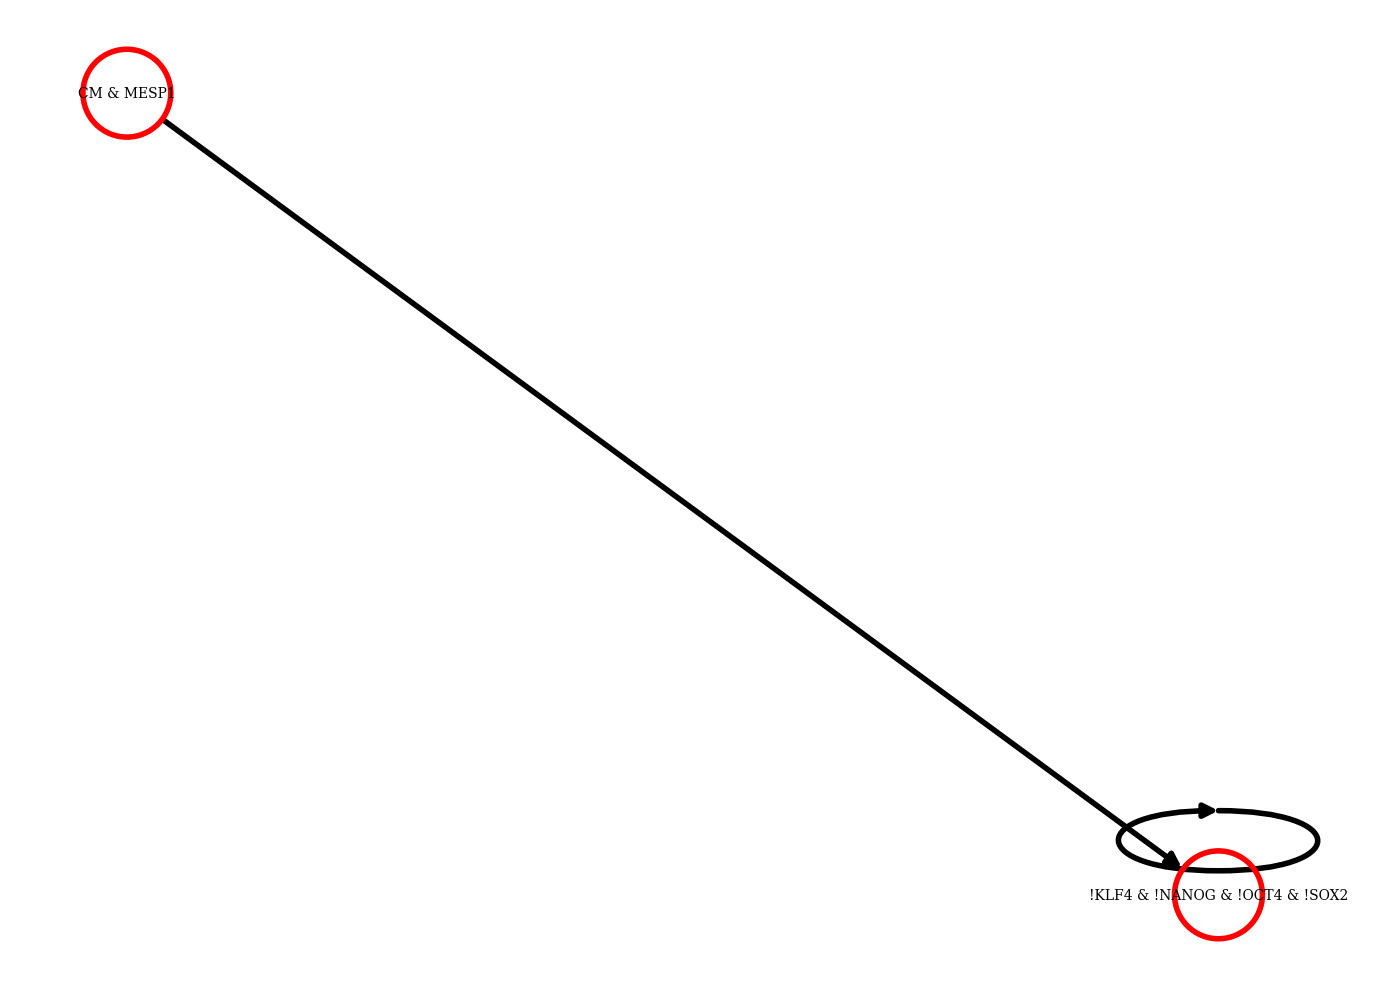

In [4]:
import util, RSC, ensemble, analyze, logic, mechanism

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/cpc_ipsc.bnet"  
params2["target"] = "(!NANOG & !OCT4 & !SOX2 & !KLF4)"  # e.g. CPC_IPSC
params2["approx"] = False
params2["analysis_order"] = 2
params2["measure_robustness"] = True
params2["find_mechanism"] = True
params2["controller"] = "(!KLF4 & MESP1)"

# 3) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 4) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 5) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 6) Pretty print or use the dict
util.pretty_print(results)

# 4) if you want plots, recompute the aux stuff (cnt_fns, drives, etc.)
controllers = logic.from_pyEda(terminal_logic)
_, self_driven, drives_self_driven, cnt_fns = analyze.calc_driven_and_self_driven(params2, F, controllers)

# 5) choose what to plot: best controllers or a specific one
to_plot = results["best controllers"] or []
if not to_plot and params2.get("controller"):
    # fall back to the single controller in params if it's in the predicate
    try:
        candidate = logic.str_to_F(params2["controller"])[0]
        if candidate in controllers:
            to_plot = [candidate]
    except Exception:
        pass

# 6) make the plots
for ctrl in to_plot:
    mechanism.find_mechanism(
        params2, F, controllers, ctrl, cnt_fns, drives_self_driven, self_driven,
        plot_it=True  # <- ensures plotting
    )

In [6]:
def print_full_basins(res):
    total = sum(res["counts_full"].values())
    items = sorted(res["counts_full"].items(), key=lambda kv: -kv[1])  # sort by basin size desc
    print(f"Full attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_full"][k]
        lam = len(k)
        states = res.get("decoded_full", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

def print_pseudo_basins(res):
    if not res.get("counts_pseudo"):
        print("No pseudo-attractor basins (pseudo_nodes not set).")
        return
    total = sum(res["counts_pseudo"].values())
    items = sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1])
    print(f"Pseudo-attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_pseudo"][k]
        lam = len(k)     # length of the projected cycle
        states = res.get("decoded_pseudo", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

In [6]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/cpc_ipsc.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

# # 5) Inspect
# print("Total simulations:", sum(res["counts_full"].values()))
# print("\nFull attractors (canonical):")
# for k, v in sorted(res["counts_full"].items(), key=lambda kv: -kv[1]):
#     print(f"  size λ={len(k)}  ->  count={v},  prob={res['probs_full'][k]:.3f}")

# print("\nPseudo-attractor basins:")
# if res["counts_pseudo"]:
#     for k, v in sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1]):
#         print(f"  cycle_len={len(k)}  pattern={k}  ->  count={v},  prob={res['probs_pseudo'][k]:.3f}")
# else:
#     print("  (none requested)")

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 1024
  λ=1  basin=430/1024  (prob=0.420)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 1, 'CM': 1, 'Y': 1}
  λ=1  basin=280/1024  (prob=0.273)
    {'NANOG': 1, 'OCT4': 1, 'SOX2': 1, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 0}
  λ=1  basin=98/1024  (prob=0.096)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 1}
  λ=1  basin=96/1024  (prob=0.094)
    {'NANOG': 1, 'OCT4': 1, 'SOX2': 1, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 0, 'ISL1': 0, 'CM': 0, 'Y': 0}
  λ=1  basin=80/1024  (prob=0.078)
    {'NANOG': 1, 'OCT4': 1, 'SOX2': 1, 'KLF4': 1, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 0}
  λ=1  basin=24/1024  (prob=0.023)
    {'NANOG': 1, 'OCT4': 1, 'SOX2': 1, 'KLF4': 1, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 0, 'ISL1': 0, 'CM': 0, 'Y': 0}
  λ=1  basin=6

In [7]:
control = {"MESP1": 1, "CM": 1}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_ctrl = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=['NANOG', 'OCT4', 'SOX2', 'KLF4', 'Y']      # also double-check names exist
)

print_full_basins(res_ctrl)
print()
print_pseudo_basins(res_ctrl)


Full attractors (with basin sizes), total sims = 256
  λ=1  basin=192/256  (prob=0.750)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 1, 'CM': 1, 'Y': 1}
  λ=1  basin=64/256  (prob=0.250)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 1}

Pseudo-attractors (with basin sizes), total sims = 256
  λ=1  basin=256/256  (prob=1.000)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Y': 1}


In [8]:
import compare_basins as cb

#cb.compare_basin_overlap_fixed(res_orig, res_ctrl, G, pseudo_nodes=['NANOG','OCT4','SOX2','KLF4','Y'])
cb.check_pattern_occupancy_fixed(res_orig, res_ctrl, G, {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Y': 1})



🎯 Pattern {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Y': 1} (evaluated over FULL attractors):
  Matching original attractors: 6 (cover 544/1024 = 0.531)
  Occupied under control: 2 (cover 528/1024 = 0.516)
  Not reached under control: 4 (cover 16/1024 = 0.016)

  Reached (examples):
   λ=1 basin=430 prob=0.420 codes=(960,)
     {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 1, 'CM': 1, 'Y': 1}

   λ=1 basin=98 prob=0.096 codes=(576,)
     {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 1}


  Unreached (examples):
   λ=1 basin=6 prob=0.006 codes=(896,)
     {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 0, 'ISL1': 1, 'CM': 1, 'Y': 1}

   λ=1 basin=6 prob=0.006 codes=(976,)
     {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 1, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 1, 'CM': 1, 'Y': 1}

   λ=1 basin=2 prob=0.002 codes=(512,)


## Ramirez Example

In [15]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="figures_material/networks/ramirez_gmp.bnet",  # or bnet_text=...
    max_per_row=4,
    max_per_row_output=4,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    osci_seed=42,
    x_gap=3, y_gap=3,          # grid spacing
    node_shape="circle",           # "circle" or "ellipse" or anything Graphviz supports
    node_width=1.2, node_height=1.2,
    fontsize=25,
    output_dir="figures_material/figure_3",
    base_name="ramirez_graph_final",
    fontname="DejaVu Sans"
)
art


{'dot': 'figures_material\\figure_3\\ramirez_graph_final.dot',
 'png': 'figures_material\\figure_3\\ramirez_graph_final.png',
 'svg': 'figures_material\\figure_3\\ramirez_graph_final.svg',
 'positions_json': 'figures_material\\figure_3\\ramirez_graph_final_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 4,
 'max_per_row_input': None,
 'max_per_row_output': 4}

all controllers        : [['!cebpa', 'bc', 'gmcsfr'], ['!cebpa', 'bc', 'il3ra'], ['!cebpa', 'gata1'], ['!cebpa', 'gata2'], ['!cebpa', 'jak2'], ['!cebpa', 'stat5'], ['!mitf', 'cebpa', 'ckit', 'runx1'], ['bc', 'ckit', 'gmcsfr'], ['bc', 'ckit', 'il3ra'], ['bc', 'gmcsfr', 'mitf'], ['bc', 'il3ra', 'mitf'], ['cebpa', 'mitf', 'pu1', 'runx1'], ['ckit', 'gata1'], ['ckit', 'gata2'], ['ckit', 'jak2'], ['ckit', 'stat5'], ['gata1', 'mitf'], ['gata2', 'mitf'], ['jak2', 'mitf'], ['mitf', 'stat5']]
relative heights       : [np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(1)]
min controllers        : [['!cebpa', 'gata1'], ['!cebpa', 'gata2'], ['!cebpa', 'jak2'], ['!cebpa', 'stat5'], ['ckit', 'gata1'], ['ckit', 'gata2'], ['ckit', 'jak2'], ['ckit', 'stat5'], ['gata1', 'mitf'], ['gata2', 'mitf'], ['jak2', 'mitf'], ['mitf', 'stat5']]
min robust controllers : [['!cebpa', 'gata1'], ['ckit', 'gata1'], ['gat

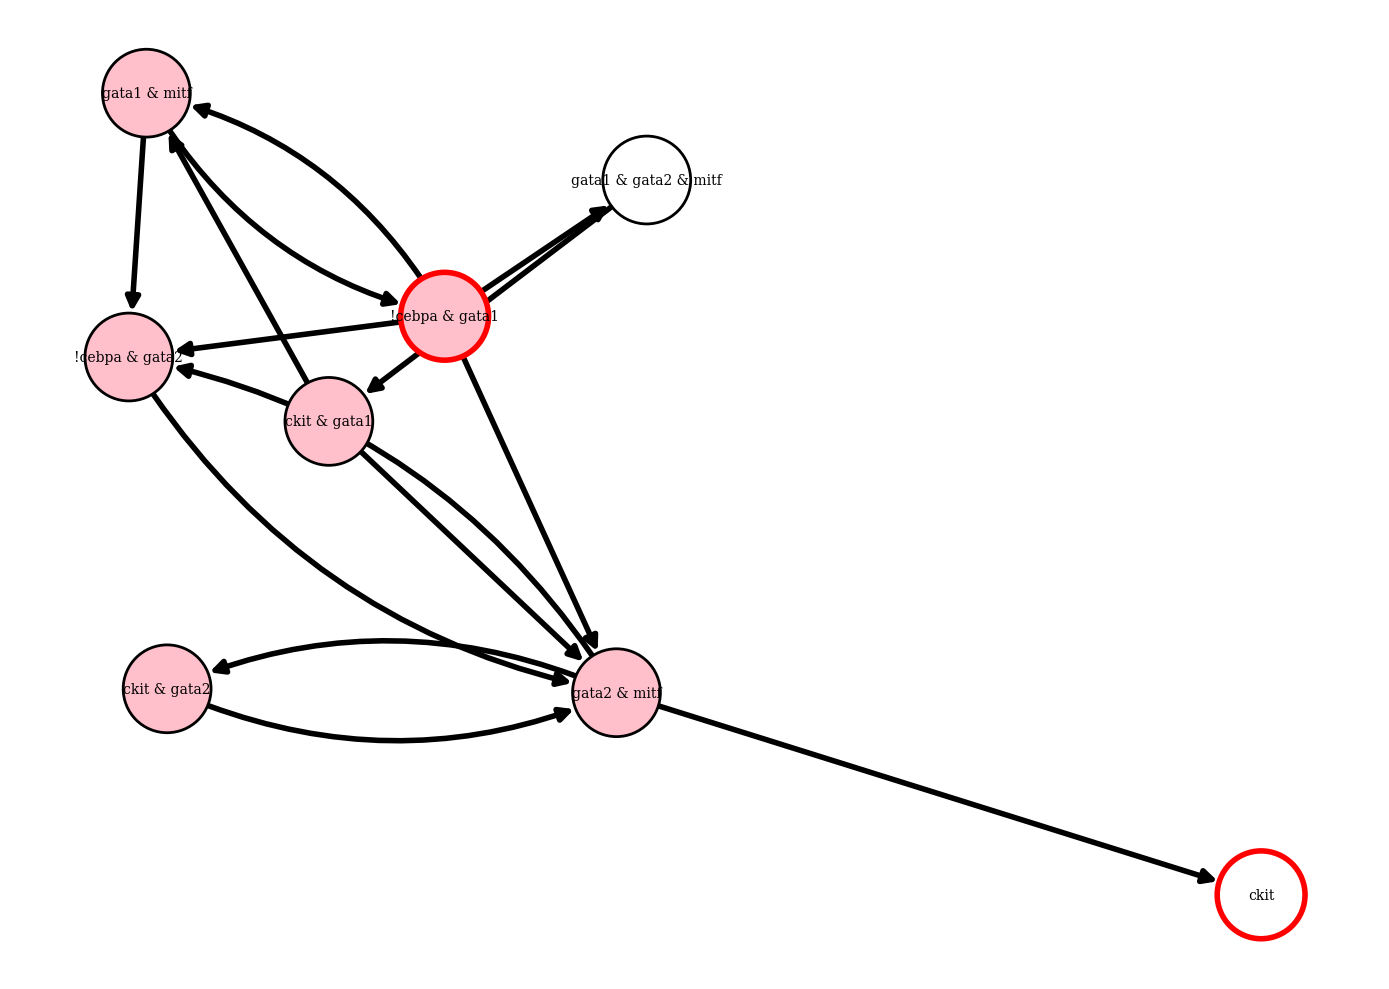

This is the controller being plotted: ['ckit', 'gata1']


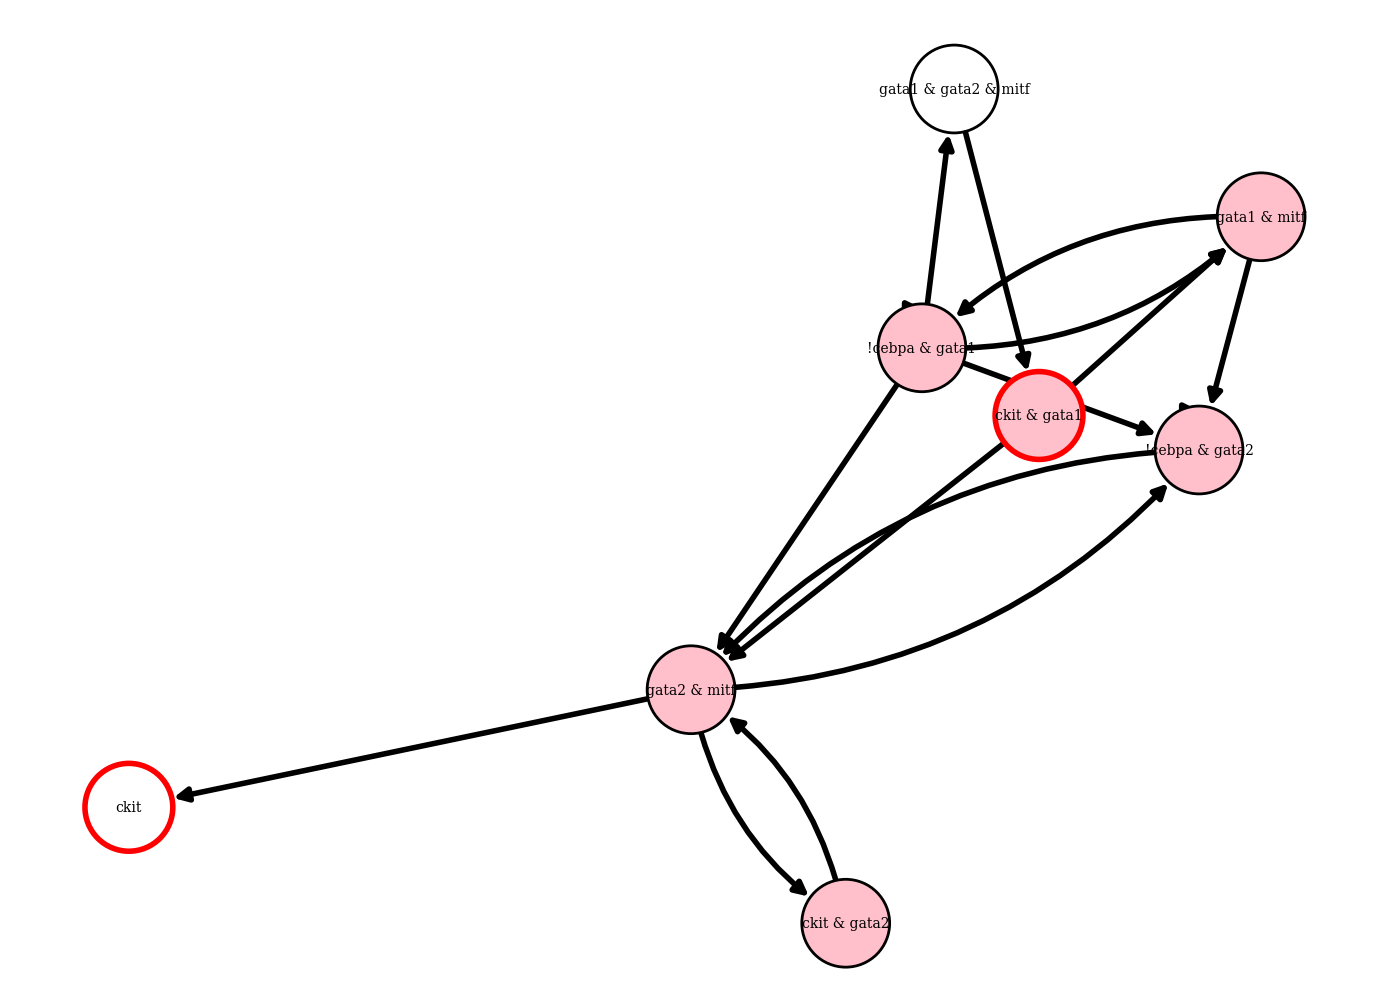

This is the controller being plotted: ['gata1', 'mitf']


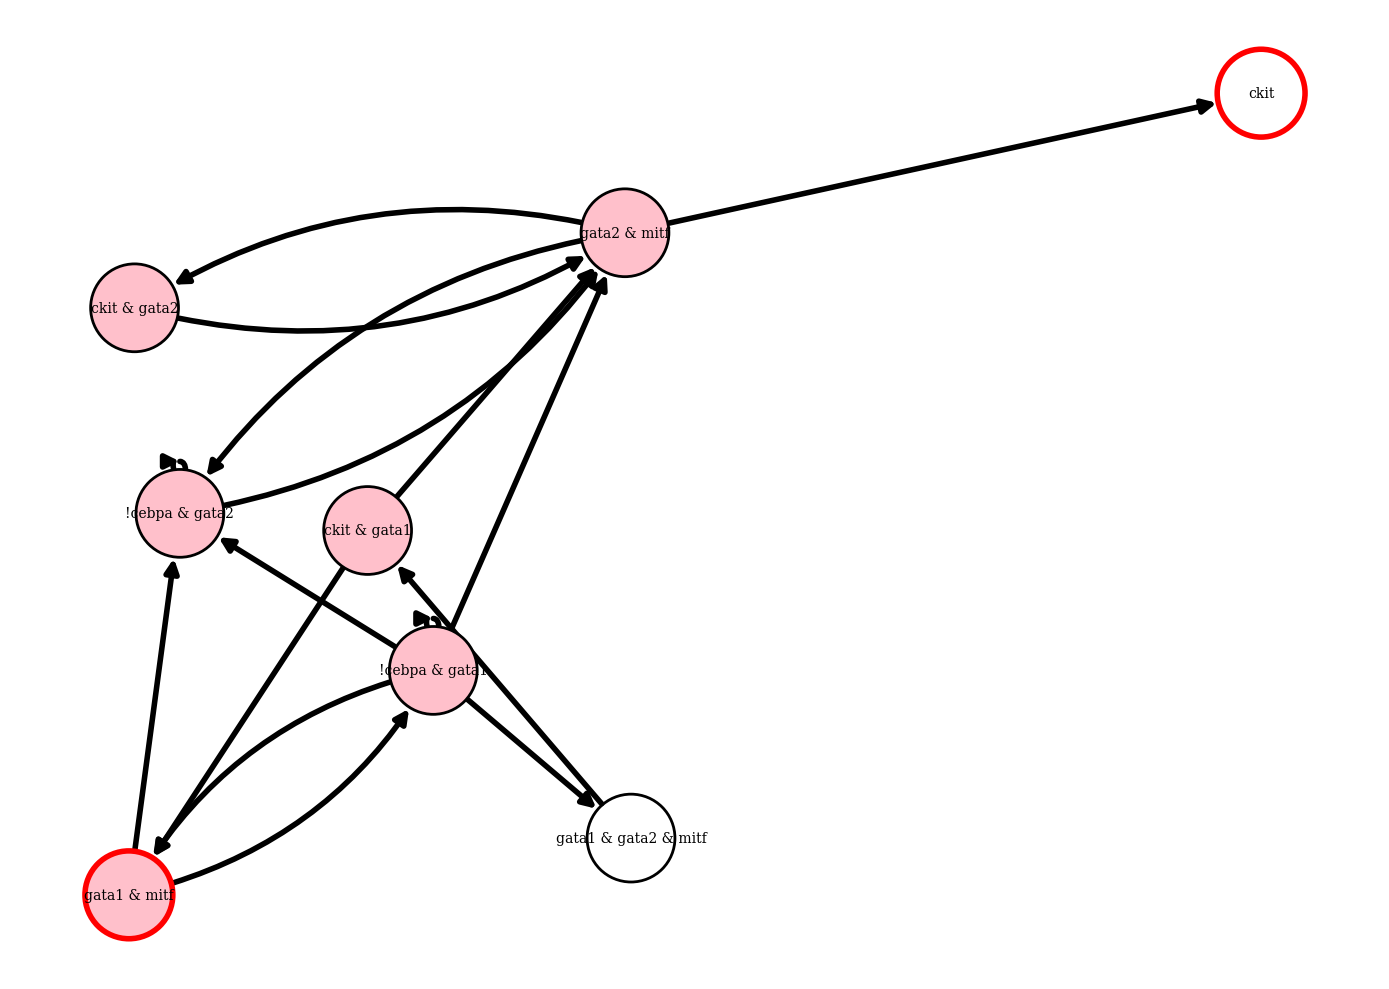

In [12]:
import sys
sys.path.append("src")
import util, RSC, ensemble, analyze, logic, mechanism
from copy import deepcopy
from other_methods import simulate, net
import basin

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/ramirez_gmp.bnet"  
params2["target"] = "ckit"  # e.g. CPC_IPSC
params2["approx"] = False
params2["analysis_order"] = 3
params2["measure_robustness"] = True
params2["find_mechanism"] = True

# 3) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 4) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 5) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 6) Pretty print or use the dict
util.pretty_print(results)

# 4) if you want plots, recompute the aux stuff (cnt_fns, drives, etc.)
controllers = logic.from_pyEda(terminal_logic)
_, self_driven, drives_self_driven, cnt_fns = analyze.calc_driven_and_self_driven(params2, F, controllers)

# 5) choose what to plot: best controllers or a specific one
to_plot = results["best controllers"] or []
if not to_plot and params2.get("controller"):
    # fall back to the single controller in params if it's in the predicate
    try:
        candidate = logic.str_to_F(params2["controller"])[0]
        if candidate in controllers:
            to_plot = [candidate]
    except Exception:
        pass

# 6) make the plots
print("Controllers to plot:", to_plot)
for ctrl in to_plot:
    print("This is the controller being plotted:", ctrl)
    mechanism.find_mechanism(
        params2, F, controllers, ctrl, cnt_fns, drives_self_driven, self_driven,
        plot_it=True  # <- ensures plotting
    )

In [13]:
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/ramirez_gmp.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=10000,
    x0_mode="auto",
    max_samples=2000,
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

# print_full_basins(res_orig)
# print()
print_pseudo_basins(res_orig)

Pseudo-attractors (with basin sizes), total sims = 2000
  λ=1  basin=1712/2000  (prob=0.856)
    {'Y': 1}
  λ=1  basin=188/2000  (prob=0.094)
    {'Y': 0}
  λ=2  basin=100/2000  (prob=0.050)
    {'Y': 0}
    {'Y': 0}


In [14]:
control = {"gata1": 1, "mitf": 1}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_ctrl = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=10000,
    x0_mode="auto",
    max_samples=2000,
    seed=42,
    record_stg=False,
    pseudo_nodes=['Y']      # also double-check names exist
)

# print_full_basins(res_ctrl)
# print()
# print_pseudo_basins(res_ctrl)

#cb.compare_basin_overlap_fixed(res_orig, res_ctrl, G, pseudo_nodes=['NANOG','OCT4','SOX2','KLF4','Y'])
cb.check_pattern_occupancy_fixed(res_orig, res_ctrl, G, {'Y': 1})


NameError: name 'cb' is not defined

In [ ]:
control = {"cebpa": 0, "gata1": 1}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_ctrl = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=10000,
    x0_mode="auto",
    max_samples=2000,
    seed=42,
    record_stg=False,
    pseudo_nodes=['Y']      # also double-check names exist
)

# print_full_basins(res_ctrl)
# print()
# print_pseudo_basins(res_ctrl)

#cb.compare_basin_overlap_fixed(res_orig, res_ctrl, G, pseudo_nodes=['NANOG','OCT4','SOX2','KLF4','Y'])
cb.check_pattern_occupancy_fixed(res_orig, res_ctrl, G, {'Y': 1})


NameError: name 'params' is not defined